In [212]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Dataset: https://github.com/owid/energy-data?tab=readme-ov-file

ONLY europe!

In [213]:
energy = pd.read_csv('data/owid-energy-data.csv')

In [214]:
consumption = ['country', 'year', 'iso_code', 'population', 'gdp',
 'wind_consumption',
 'solar_consumption',
 'other_renewable_consumption',
 'oil_consumption',
 'nuclear_consumption',
 'hydro_consumption',
 'gas_consumption',
 'coal_consumption',
 'biofuel_consumption',]

In [215]:
energy = energy[energy['year'] == 2019]

In [216]:
# keep only the columns we need
energy = energy[consumption]
energy.dropna(inplace=True)

In [217]:
share = energy.drop(columns=['country', 'year', 'iso_code', 'population', 'gdp'])
share.index = energy['country']

<Axes: title={'center': 'Bartik IV for France'}, xlabel='Consumption', ylabel='Energy source'>

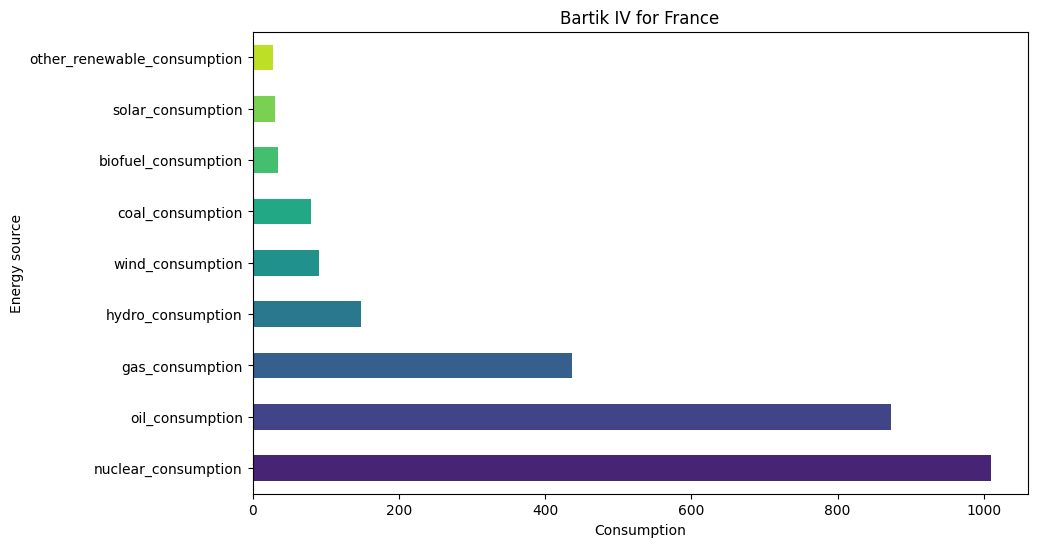

In [218]:
country = 'France'
share.loc[country].sort_values(ascending=False).plot(
    kind='barh',
    title=f'Bartik IV for {country}',
    xlabel='Consumption',
    ylabel='Energy source',
    figsize=(10, 6),
    color=sns.color_palette("viridis", len(share.columns))
)

In [219]:
share = share.div(share.sum(axis=1), axis=0)

In [220]:
mean_shares = share.mean()

In [221]:
mean_shares.sort_values(ascending=False, inplace=True)
mean_shares

oil_consumption                0.381066
gas_consumption                0.225697
coal_consumption               0.174941
hydro_consumption              0.088659
nuclear_consumption            0.055092
wind_consumption               0.030536
other_renewable_consumption    0.024421
solar_consumption              0.010104
biofuel_consumption            0.009483
dtype: float64

In [222]:
HHI = (mean_shares ** 2).sum()
effective_N = 1 / HHI
print(f"Herfindahl index: {HHI:.3f}, Effective shocks: {effective_N:.0f}")


Herfindahl index: 0.239, Effective shocks: 4


In [223]:
share.to_csv('data/shares.csv')

In [224]:
energy_price_shock = {
    # Fossil‑fuel components (no aggregate)
    "oil_consumption": 0.329,      # +32.9 %
    "gas_consumption": 0.934,      # +93.4 %
    "coal_consumption": 1.234,     # +123.4 %

    # Low‑carbon components
    "nuclear_consumption": 0.102,  # +10.2 % (uranium)
    "hydro_consumption": 0.0,
    "wind_consumption": 0.0,
    "solar_consumption": 0.0,
    "other_renewable_consumption": 0.0,
    "biofuel_consumption": 0.3
}


In [225]:
# Step 3: Ensure all columns in the price shock dict are in the dataframe
common_cols = [col for col in energy_price_shock if col in share.columns]

# Step 4: Compute the Bartik IV as the dot product of shares × global shocks
share["bartik_iv"] = share[common_cols].dot(pd.Series(energy_price_shock))


In [226]:
bartik_iv = share["bartik_iv"]

bartik_iv.sort_values(ascending=False)
bartik_iv.to_csv('data/bartik_iv.csv')

In [227]:
bartik_iv

country
Argentina          0.602073
Australia          0.720781
Austria            0.413523
Belarus            0.747472
Belgium            0.457305
Brazil             0.302013
Bulgaria           0.585559
Canada             0.436812
China              0.842612
Colombia           0.464282
Croatia            0.474554
Czechia            0.694619
Denmark            0.359223
Ecuador            0.245324
Estonia            0.856503
Finland            0.345923
France             0.331933
Germany            0.557082
Greece             0.500616
Hong Kong          0.571910
Hungary            0.565517
India              0.820400
Indonesia          0.744328
Ireland            0.501603
Israel             0.708317
Italy              0.545709
Japan              0.654046
Kazakhstan         0.920475
Latvia             0.449852
Lithuania          0.511400
Luxembourg         0.424366
Malaysia           0.707501
Mexico             0.616587
Netherlands        0.592224
New Zealand        0.375343
North Macedo

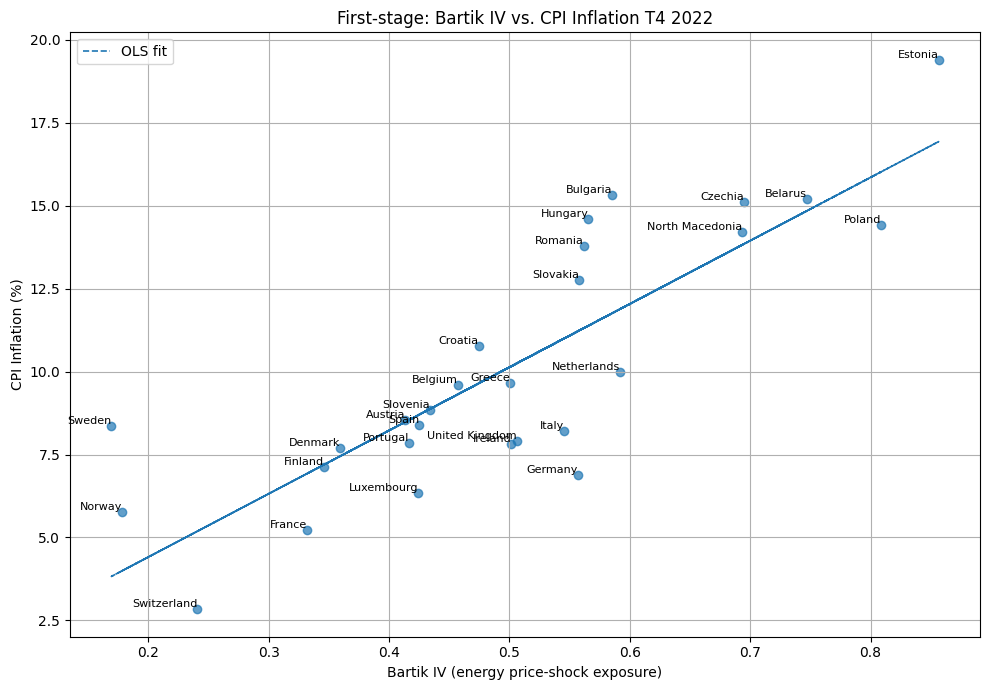

In [228]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ---------- 1. Load the Bartik IV values ----------
bartik = pd.read_csv('data/bartik_iv.csv')  # expects columns: country, bartik_iv

# ---------- 2. Load World‑Bank CPI inflation data (annual %) ----------
wb = pd.read_csv('data/world_inflation.csv', skiprows=4)  # WB format: data start after four header rows

# Keep only 2022 inflation values
wb_2022 = wb[['Country Name', 'Country Code', '2022']].rename(columns={'2022': 'inflation_2022'})

# ---------- 3. Map country names where WB differs ----------
name_map = {
    'Hong Kong': 'Hong Kong SAR, China',
    'South Korea': 'Korea, Rep.',
    'Russia': 'Russian Federation',
    'Slovakia': 'Slovak Republic',
    'Taiwan': 'Taiwan, China',
}
bartik['wb_country'] = bartik['country'].replace(name_map)

# ---------- 4. Merge and clean ----------
merged = bartik.merge(wb_2022, left_on='wb_country', right_on='Country Name', how='left')
merged = merged.dropna(subset=['inflation_2022'])

# Convert inflation to numeric and drop high-inflation countries
merged['inflation_2022'] = pd.to_numeric(merged['inflation_2022'], errors='coerce')
merged = merged[merged['inflation_2022'] <= 30]

europe_or_nearby = [
    "Austria", "Belarus", "Belgium", "Bulgaria", "Croatia", "Czechia",
    "Denmark", "Finland", "France", "Germany", "Greece",
    "Hungary", "Ireland", "Italy", "Estonia",
    "Luxembourg", "Netherlands", "North Macedonia", "Norway", "Poland",
    "Portugal", "Romania", "Slovakia", "Slovenia", "Spain", "Sweden",
    "Switzerland", "United Kingdom"]

# outliers: "Kazakhstan", "Latvia", "Lithuania", "Estonia"

merged = merged[merged['country'].isin(europe_or_nearby)]

# ---------- 5. Plot with country names ----------
x = merged['bartik_iv'].values
y = merged['inflation_2022'].values
names = merged['country'].values



# Fit OLS line
m, b = np.polyfit(x, y, 1)

plt.figure(figsize=(10, 7))
plt.scatter(x, y, alpha=0.7)

# Label each point
for i, name in enumerate(names):
    plt.text(x[i], y[i], name, fontsize=8, ha='right', va='bottom')

# Plot fitted line
plt.plot(x, m * x + b, linestyle='--', linewidth=1.2, label='OLS fit')

plt.title("First-stage: Bartik IV vs. CPI Inflation T4 2022")
plt.xlabel("Bartik IV (energy price-shock exposure)")
plt.ylabel("CPI Inflation (%)")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


In [229]:
names

array(['Austria', 'Belarus', 'Belgium', 'Bulgaria', 'Croatia', 'Czechia',
       'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece',
       'Hungary', 'Ireland', 'Italy', 'Luxembourg', 'Netherlands',
       'North Macedonia', 'Norway', 'Poland', 'Portugal', 'Romania',
       'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland',
       'United Kingdom'], dtype=object)

In [230]:
import statsmodels.api as sm

# Filter to only European and near-European countries
filtered = merged[merged['country'].isin(europe_or_nearby)]

# Drop high inflation countries (> 30%)
filtered = filtered[filtered['inflation_2022'] <= 30]

# Prepare X and y for regression
X = sm.add_constant(filtered['bartik_iv'])  # add intercept
y = filtered['inflation_2022']

model = sm.OLS(y, X).fit()

# Regression results summary
regression_summary = model.summary().as_text()

# Output regression summary
print(regression_summary)


                            OLS Regression Results                            
Dep. Variable:         inflation_2022   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     59.53
Date:                Sun, 04 May 2025   Prob (F-statistic):           3.47e-08
Time:                        15:16:04   Log-Likelihood:                -60.488
No. Observations:                  28   AIC:                             125.0
Df Residuals:                      26   BIC:                             127.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5914      1.299      0.455      0.6